In [1]:
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import tqdm
import sys
import pickle
import PyComplexHeatmap as pch
import scvi
import IPython

sc.settings.figdir=os.path.expanduser('~/WbFigures/V1Analysis')
sc._settings.settings._vector_friendly=True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")

sys.path.append('/home/matthew.schmitz/utils/mts-utils/')
from genomics import sc_analysis


import sys
import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/antipode/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is not available


In [2]:
print('is this on?')

is this on?


In [3]:
antipode_model=antipode.antipode_model.ANTIPODE.load('/home/matthew.schmitz/Matthew/models/1.9.1.8.3_V1AllNoPsi-NoReLU/',prefix='p4_',device=device)#adata=adata
adata=antipode_model.adata_manager.adata

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/antipode/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[UMIs] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [4]:
adata=adata.to_memory()

In [5]:
adata.layers['norm_UMIs']=adata.layers['UMIs'].copy()
adata.layers['norm_UMIs']=scipy.sparse.csr_matrix(1e4*(adata.layers['norm_UMIs']/adata.layers['norm_UMIs'].sum(1)))

In [6]:
#For PyComplexHeatmap need to register palettes
gs1=matplotlib.colors.ListedColormap(sc.pl.palettes.godsnot_102,name='godsnot_102')
matplotlib.cm.register_cmap(name='godsnot_102',cmap=gs1)
gs2=matplotlib.colors.ListedColormap(sc.pl.palettes.godsnot_102+sc.pl.palettes.godsnot_102+sc.pl.palettes.godsnot_102,name='godsnot_big')
matplotlib.cm.register_cmap(name='godsnot_big',cmap=gs2)

/scratch/fast/16080181/ipykernel_16684/1383309273.py:3: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap(name='godsnot_102',cmap=gs1)
/scratch/fast/16080181/ipykernel_16684/1383309273.py:5: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap(name='godsnot_big',cmap=gs2)


In [7]:
batch_key='batch_name'
discov_key='species'
layer_key='UMIs'
MDE_KEY = "X_antipode_MDE"

In [8]:
sc.tl.dendrogram(adata,groupby='level_2',use_rep='X_antipode')

In [9]:
pstore=adata.uns['param_store']
n_clusters=antipode_model.level_sizes[-1]

In [10]:
prefix=''
level_edges=[numpy_hardmax(antipode_model.adata_manager.adata.uns[prefix+'param_store']['edges_'+str(i)],axis=-1) for i in range(len(antipode_model.level_sizes)-1)]
levels=antipode_model.tree_convergence_bottom_up.just_propagate(np.eye(antipode_model.level_sizes[-1]),level_edges)
prop_taxon=np.concatenate(levels,axis=-1)

In [11]:
discov_labels=adata.obs[antipode_model.discov_key].cat.categories
latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
cluster_index=sorted(adata.obs['level_2'].astype(int).unique())#list(range(antipode_model.level_sizes[-1]))#list(range(pstore['locs'].shape[0]))
cluster_labels=[str(x) for x in cluster_index]#adapt
cluster_label_dict=dict(zip(cluster_index,cluster_labels))
var_labels=adata.var.index

In [12]:
prop_locs=prop_taxon@pstore['locs']
prop_cluster_intercept=prop_taxon@pstore['cluster_intercept']
cluster_params=(prop_locs@pstore['z_decoder_weight'])+prop_cluster_intercept
cluster_params=cluster_params[cluster_index,:]

In [13]:
#Need to propagate multilayer tree to discovs
prop_discov_di = np.einsum('pc,dcg->dpg',prop_taxon,pstore['discov_di'])
prop_discov_dm = np.einsum('pc,dcm->dpm',prop_taxon,pstore['discov_dm'])
discov_cluster_params=np.einsum('dpm,dmg->dpg',prop_locs+prop_discov_dm,pstore['z_decoder_weight']+pstore['discov_dc'])+(prop_cluster_intercept+prop_discov_di+np.expand_dims(pstore['discov_constitutive_de'],1))

In [14]:
aggr_means=antipode.model_functions.group_aggr_anndata(adata,['species','level_2'],layer='norm_UMIs')
log_real_means=np.log(aggr_means[0]+1e-3)

100%|██████████| 1008/1008 [00:39<00:00, 25.35it/s]


<Axes: ylabel='Count'>

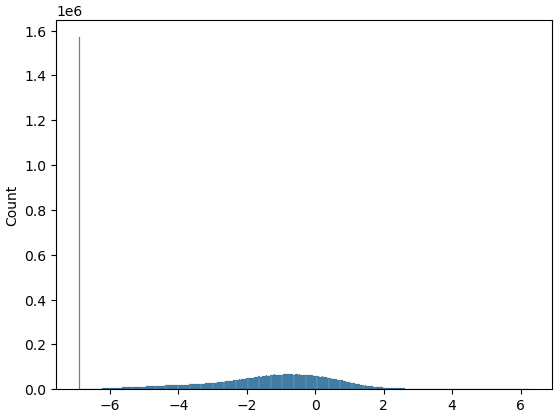

In [15]:
seaborn.histplot(log_real_means.flatten())

In [16]:
centered_discov_cluster_params=discov_cluster_params[:,cluster_index,:]-discov_cluster_params[:,cluster_index,:].mean(0)

In [17]:
pstore.keys()

dict_keys(['batch_di', 'batch_dm', 'cluster_intercept', 'discov_constitutive_de', 'discov_dc', 'discov_di', 'discov_dm', 'edges_0', 'edges_1', 'locs', 'locs_dynam', 'quality_genes', 's_inverse_dispersion', 'scales', 'z_decoder_weight'])

In [18]:
centered_aggr_means=log_real_means-log_real_means.mean(0)

In [19]:
log_real_means.shape

(8, 126, 10273)

<Axes: >

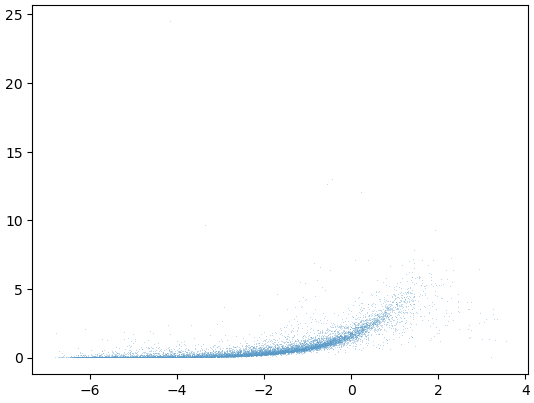

In [20]:
seaborn.scatterplot(x=log_real_means.mean(0).mean(0),y=pstore['s_inverse_dispersion'],s=0.2)

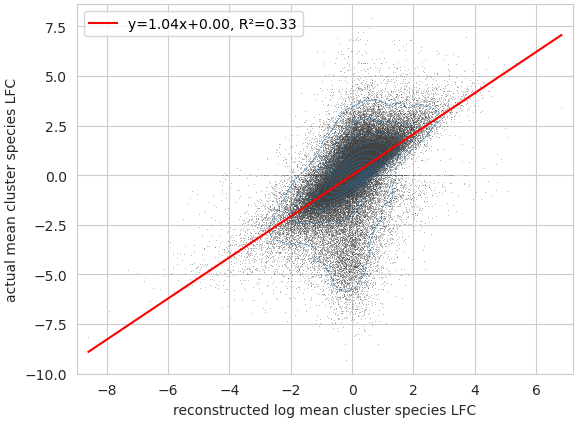

In [30]:
randinds=np.random.choice(np.array(list(range(centered_aggr_means.flatten().shape[0]))),size=100000,replace=False)
with seaborn.axes_style("whitegrid"):
    seaborn.scatterplot(x=centered_discov_cluster_params.flatten()[randinds],y=centered_aggr_means.flatten()[randinds],s=0.2,color='black')
    seaborn.kdeplot(x=centered_discov_cluster_params.flatten()[randinds],y=centered_aggr_means.flatten()[randinds],linestyles='--', linewidths=0.5)
    plt.xlabel('reconstructed log mean cluster species LFC')
    plt.ylabel('actual mean cluster species LFC')

# Calculate the regression parameters
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(centered_discov_cluster_params.flatten(),centered_aggr_means.flatten())

# Plot the regression line
x_values = np.linspace(np.min(centered_discov_cluster_params.flatten()[randinds]), np.max(centered_discov_cluster_params.flatten()[randinds]), 100)
plt.plot(x_values, slope * x_values + intercept, color='red', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')

# Add legend
plt.legend()


Text(0, 0.5, 'actual mean cluster exp (counts/1e4)')

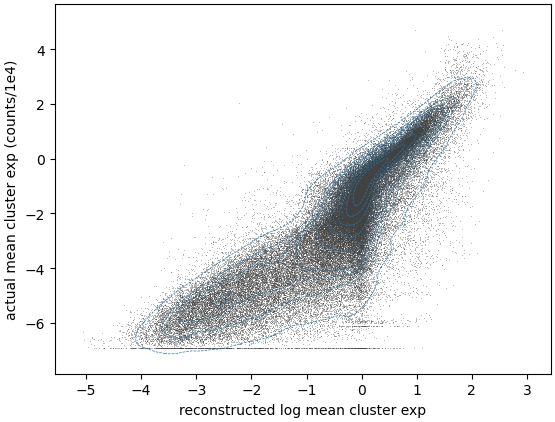

In [22]:
randinds=np.random.choice(np.array(list(range(log_real_means.mean(0).flatten().shape[0]))),size=100000,replace=False)
seaborn.scatterplot(x=cluster_params.flatten()[randinds],y=log_real_means.mean(0).flatten()[randinds],s=0.2,color='black')
seaborn.kdeplot(x=cluster_params.flatten()[randinds],y=log_real_means.mean(0).flatten()[randinds],linestyles='--', linewidths=0.5)
plt.xlabel('reconstructed log mean cluster exp')
plt.ylabel('actual mean cluster exp (counts/1e4)')

In [23]:
def melt_param_3d(X,discov_labels,cluster_labels,var_labels):
    dfs=[]
    for i in range(len(discov_labels)):
        for j in range(len(cluster_labels)):
            df=pd.DataFrame(X[i,j,:],columns=['value'])
            df['discov']=discov_labels[i]
            df['cluster']=cluster_labels[j]
            df['var']=var_labels
            dfs.append(df)
    return(pd.concat(dfs,axis=0))

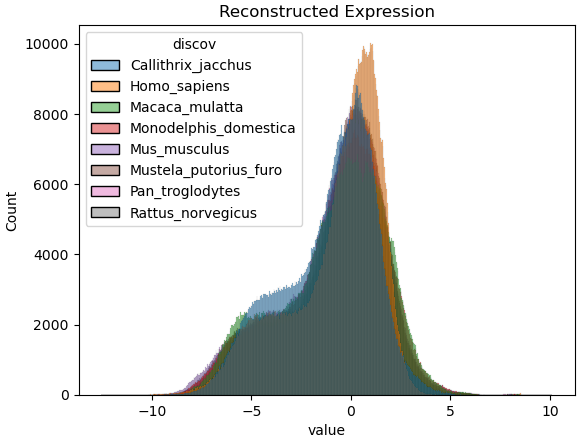

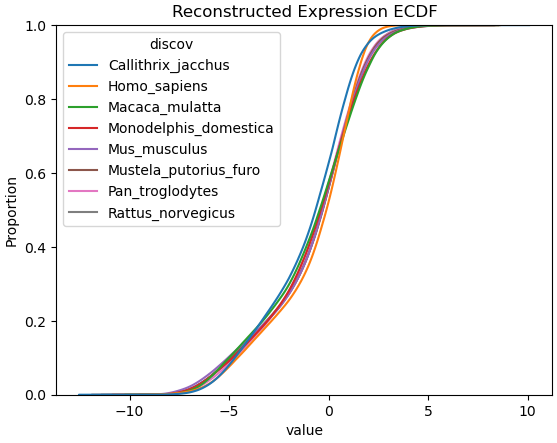

In [24]:
melted_reconstruction=melt_param_3d(discov_cluster_params,discov_labels,cluster_labels,var_labels)
seaborn.histplot(data=melted_reconstruction,x='value',hue='discov')
plt.title('Reconstructed Expression')
plt.show()
seaborn.ecdfplot(data=melted_reconstruction,x='value',hue='discov')
plt.title('Reconstructed Expression ECDF')
plt.show()

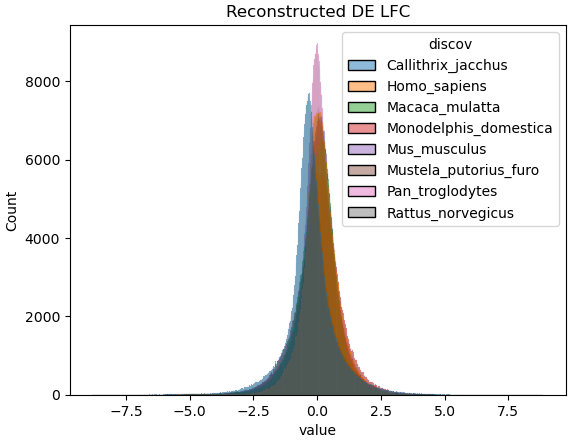

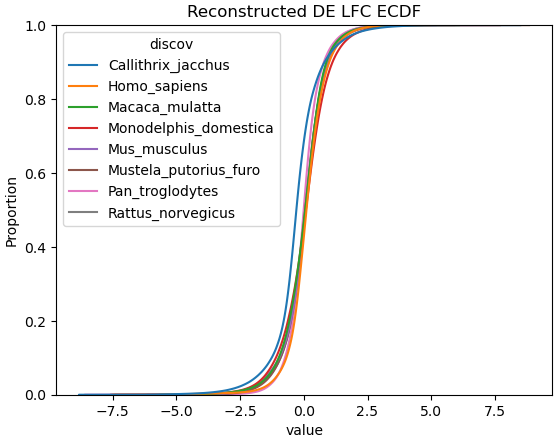

In [25]:
melted_reconstruction_fc=melt_param_3d(centered_discov_cluster_params,discov_labels,cluster_labels,var_labels)
seaborn.histplot(data=melted_reconstruction_fc,x='value',hue='discov')
plt.title('Reconstructed DE LFC')
plt.show()
seaborn.ecdfplot(data=melted_reconstruction_fc,x='value',hue='discov')
plt.title('Reconstructed DE LFC ECDF')
plt.show()

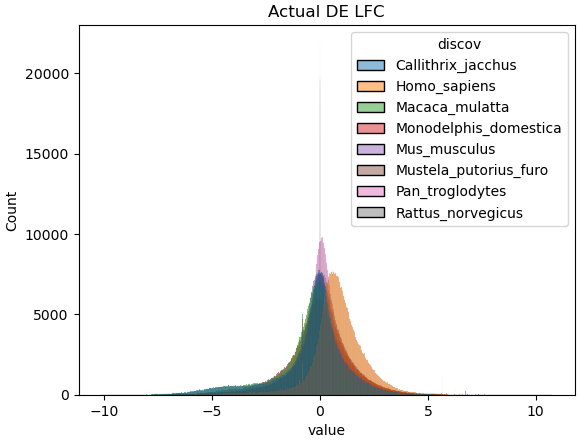

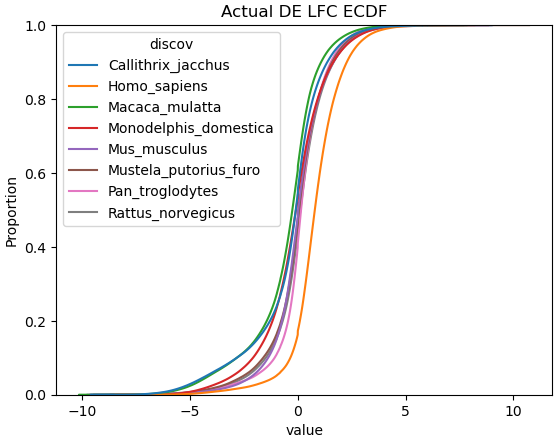

In [26]:
melted_mean_fcs=melt_param_3d(centered_aggr_means,discov_labels,cluster_labels,var_labels)
seaborn.histplot(data=melted_mean_fcs,x='value',hue='discov')
plt.title('Actual DE LFC')
plt.show()
seaborn.ecdfplot(data=melted_mean_fcs,x='value',hue='discov')
plt.title('Actual DE LFC ECDF')
plt.show()

In [ ]:
melted_means=melt_param_3d(log_real_means,discov_labels,cluster_labels,var_labels)
seaborn.histplot(data=melted_means,x='value',hue='discov')
plt.title('Actual Expression')
plt.show()
seaborn.ecdfplot(data=melted_means,x='value',hue='discov')
plt.title('Actual Expression ECDF')
plt.show()


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7fd0e5a7b1a0> (for post_execute), with arguments args (),kwargs {}:


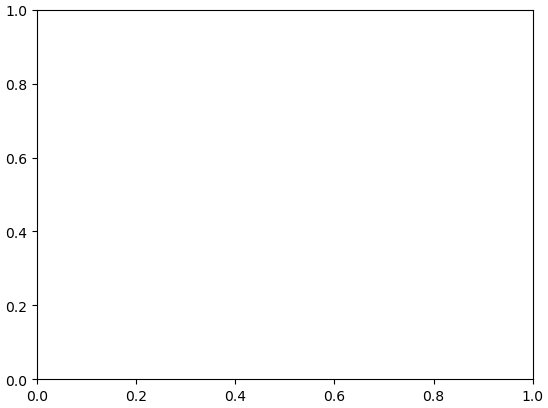

In [28]:
window_size=501
def moving_average_values(x,y,window_size=101):
    moving_average = antipode.plotting.moving_average(np.absolute(centered_discov_cluster_params).max(0).flatten()[np.argsort(coefs.flatten())],window_size)
    return(np.sort(coefs.flatten()[int(window_size/2):-int(window_size/2)]),moving_average)

## Specific markers

cluster - max

In [29]:
coefs=[]
for i in tqdm.tqdm(range(cluster_params.shape[0])):
    others=list(set(list(range(cluster_params.shape[0])))-set([i]))
    coefs.append((cluster_params[i:(i+1),:]-cluster_params[others,:].max(0)))#/(cluster_params.std(0)+cluster_params.std(0).mean()))
coefs=np.concatenate(coefs,axis=0)
cdf=pd.DataFrame(coefs.T,index=adata.var.index,columns=cluster_labels)
marker_gene_order=cdf.idxmax(0)[adata.uns['dendrogram_level_2']['categories_ordered']].unique()

cx=coefs.flatten()
cy=np.absolute(centered_discov_cluster_params).max(0).flatten()
seaborn.scatterplot(x=cx,y=cy,s=0.2)
ma_x,ma_y=moving_average_values(coefs.flatten(),np.absolute(centered_discov_cluster_params).max(0).flatten(),window_size)
plt.plot(ma_x,ma_y, color='red',linewidth=0.2, label=f'Moving Average ({window_size} points)')
plt.xlabel('specificity')
plt.ylabel('max DE LFC')
plt.show()

sc.pl.dotplot(adata,groupby='level_2',var_names=marker_gene_order,dendrogram='dendrogram_level_2',standard_scale='var',use_raw=False,cmap='coolwarm')

 79%|███████▊  | 99/126 [00:00<00:00, 367.87it/s]

KeyboardInterrupt



## Antimarkers

In [ ]:
coefs=[]
for i in tqdm.tqdm(range(cluster_params.shape[0])):
    others=list(set(list(range(cluster_params.shape[0])))-set([i]))
    coefs.append((cluster_params[i:(i+1),:]-cluster_params[others,:].mean(0)))
coefs=np.concatenate(coefs,axis=0)
cdf=pd.DataFrame(coefs.T,index=adata.var.index,columns=cluster_labels)

cx=coefs.flatten()
cy=np.absolute(centered_discov_cluster_params).max(0).flatten()
seaborn.scatterplot(x=cx,y=cy,s=0.2)
ma_x,ma_y=moving_average_values(cx,cy,window_size)
plt.plot(ma_x,ma_y, color='red',linewidth=0.2, label=f'Moving Average ({window_size} points)')
plt.xlabel('specificity')
plt.ylabel('max DE LFC')
plt.show()

marker_gene_order=cdf.idxmin(0)[adata.uns['dendrogram_level_2']['categories_ordered']].unique()
sc.pl.dotplot(adata,groupby='level_2',var_names=marker_gene_order,dendrogram='dendrogram_level_2',standard_scale='var',use_raw=False,cmap='coolwarm')

## Robust Markers

cluster - mean

In [ ]:
coefs=[]
for i in tqdm.tqdm(range(cluster_params.shape[0])):
    others=list(set(list(range(cluster_params.shape[0])))-set([i]))
    coefs.append((cluster_params[i:(i+1),:]-cluster_params[others,:].mean(0)))#/(cluster_params.std(0)+cluster_params.std(0).mean()))
coefs=np.concatenate(coefs,axis=0)
cdf=pd.DataFrame(coefs.T,index=adata.var.index,columns=cluster_labels)
marker_gene_order=cdf.idxmax(0)[adata.uns['dendrogram_level_2']['categories_ordered']].unique()

cx=coefs.flatten()
cy=np.absolute(centered_discov_cluster_params).max(0).flatten()
seaborn.scatterplot(x=cx,y=cy,s=0.2)
ma_x,ma_y=moving_average_values(cx,cy,window_size)
plt.plot(ma_x,ma_y, color='red',linewidth=0.2, label=f'Moving Average ({window_size} points)')
plt.xlabel('specificity')
plt.ylabel('max DE LFC')
plt.show()

sc.pl.dotplot(adata,groupby='level_2',var_names=marker_gene_order,dendrogram='dendrogram_level_2',standard_scale='var',use_raw=False,cmap='coolwarm')


## Real Specific

In [ ]:
coefs=[]
real_cluster_params=log_real_means.mean(0)

for i in tqdm.tqdm(range(real_cluster_params.shape[0])):
    others=list(set(list(range(real_cluster_params.shape[0])))-set([i]))
    coefs.append((real_cluster_params[i:(i+1),:]-real_cluster_params[others,:].max(0)))
coefs=np.concatenate(coefs,axis=0)
cdf=pd.DataFrame(coefs.T,index=adata.var.index,columns=cluster_labels)
marker_gene_order=cdf.idxmax(0)[adata.uns['dendrogram_level_2']['categories_ordered']].unique()

cx=coefs.flatten()
cy=np.absolute(centered_aggr_means).max(0).flatten()
seaborn.scatterplot(x=cx,y=cy,s=0.2)
ma_x,ma_y=moving_average_values(cx,cy,window_size)
plt.plot(ma_x,ma_y, color='red',linewidth=0.2, label=f'Moving Average ({window_size} points)')
plt.xlabel('specificity')
plt.ylabel('max DE LFC')
plt.show()

sc.pl.dotplot(adata,groupby='level_2',var_names=marker_gene_order,dendrogram='dendrogram_level_2',standard_scale='var',use_raw=False,cmap='coolwarm')


## Real Antimarkers

In [ ]:
coefs=[]
real_cluster_params=log_real_means.mean(0)

for i in tqdm.tqdm(range(real_cluster_params.shape[0])):
    others=list(set(list(range(real_cluster_params.shape[0])))-set([i]))
    coefs.append((real_cluster_params[i:(i+1),:]-real_cluster_params[others,:].mean(0)))
coefs=np.concatenate(coefs,axis=0)
cdf=pd.DataFrame(coefs.T,index=adata.var.index,columns=cluster_labels)
marker_gene_order=cdf.idxmin(0)[adata.uns['dendrogram_level_2']['categories_ordered']].unique()


cx=coefs.flatten()
cy=np.absolute(centered_aggr_means).max(0).flatten()
seaborn.scatterplot(x=cx,y=cy,s=0.2)
ma_x,ma_y=moving_average_values(cx,cy,window_size)
plt.plot(ma_x,ma_y, color='red',linewidth=0.2, label=f'Moving Average ({window_size} points)')
plt.xlabel('specificity')
plt.ylabel('max DE LFC')
plt.show()

sc.pl.dotplot(adata,groupby='level_2',var_names=marker_gene_order,dendrogram='dendrogram_level_2',standard_scale='var',use_raw=False,cmap='coolwarm')

## Real Robust

In [ ]:
coefs=[]
real_cluster_params=log_real_means.mean(0)

for i in tqdm.tqdm(range(real_cluster_params.shape[0])):
    others=list(set(list(range(real_cluster_params.shape[0])))-set([i]))
    coefs.append((real_cluster_params[i:(i+1),:]-real_cluster_params[others,:].mean(0)))
coefs=np.concatenate(coefs,axis=0)
cdf=pd.DataFrame(coefs.T,index=adata.var.index,columns=cluster_labels)
marker_gene_order=cdf.idxmax(0)[adata.uns['dendrogram_level_2']['categories_ordered']].unique()

cx=coefs.flatten()
cy=np.absolute(centered_aggr_means).max(0).flatten()
seaborn.scatterplot(x=cx,y=cy,s=0.2)
ma_x,ma_y=moving_average_values(cx,cy,window_size)
plt.plot(ma_x,ma_y, color='red',linewidth=0.2, label=f'Moving Average ({window_size} points)')
plt.xlabel('specificity')
plt.ylabel('max DE LFC')
plt.show()

sc.pl.dotplot(adata,groupby='level_2',var_names=marker_gene_order,dendrogram='dendrogram_level_2',standard_scale='var',use_raw=False,cmap='coolwarm')

In [ ]:
def calculate_marker_genes(adata, discov_column='species', cluster_column='level_2'):
    # Dictionary to hold the DataFrames for each species
    marker_genes_dict = {}

    # Unique species in the dataset
    species_list = adata.obs[discov_column].unique()

    # Iterate over each species
    for species in species_list:
        print(f"Processing species: {species}")
        # Subset the data for the current species
        adata_species = adata[adata.obs[discov_column] == species].copy()
        
        # Calculate marker genes for each cluster
        sc.tl.rank_genes_groups(adata_species, groupby=cluster_column, method='t-test')
        
        # Extract marker genes data into a DataFrame
        result = adata_species.uns['rank_genes_groups']
        groups = result['names'].dtype.names
        
        # Create a DataFrame to collect all clusters' results for this species
        all_clusters = []
        for group in groups:
            df = pd.DataFrame({
                'names': result['names'][group],
                'scores': result['scores'][group],
                'logfoldchanges': result['logfoldchanges'][group],
                'pvals': result['pvals'][group],
                'pvals_adj': result['pvals_adj'][group],
                'cluster': [group] * len(result['names'][group])
            })
            all_clusters.append(df)
        
        # Concatenate all cluster results into a single DataFrame and add to the dictionary
        marker_genes_dict[species] = pd.concat(all_clusters, ignore_index=True)

    return marker_genes_dict

# Assuming `adata` is your AnnData object
marker_genes_per_species = calculate_marker_genes(adata)


In [ ]:
sdfdas

In [ ]:
import memento 

In [ ]:
adata=adata.to_memory()

In [ ]:
adata.X=adata.layers['UMIs'].copy()

In [ ]:
adata.obs['capture_rate'] = 0.07
memento.setup_memento(adata, q_column='capture_rate')
memento.create_groups(adata, label_columns=['species', 'batch_name'])
memento.compute_1d_moments(adata, min_perc_group=.7)


In [ ]:
adata.uns['memento']['1d_moments'].keys()

In [ ]:
sample_meta = memento.get_groups(adata)
# The covariate DataFrame - pick the covariate columns
cov_df = sample_meta[['chr_expr_avg']]

# The treatment DataFrame - pick the treatment column
treat_df = sample_meta[['stim']]
memento.ht_1d_moments(
    adata, 
    treatment=treat_df,
    covariate=cov_df,
    resampling='bootstrap',
    num_boot=5000, 
    verbose=1,
    num_cpus=1)
